###############################################################################################

# **Spectral Vegetation Indices**

###############################################################################################

# 1. Introduction

Welcome to the first exercise on vegetation and drought monitoring. In this notebook you will learn how to work with rasterfiles in python and how to execute simple calculations. The goal is to calculate some usefull spectral vegetation indices. Herefor we will make use of top of canopy (TOC) reflectance values from the Sentinel 2 mission.

Notebook outline:

- [1. Introduction](#1.-Introduction)
- [2. Libraries](#2.-Libraries)
- [3. Quick Display](#3.-Quick-Display)
- [4. Read Data](#4.-Read-Data)
- [5. Preprocessing](#5.-Preprocessing)
- [6. Vegetation Index Computation](#6.-Vegetation-Index-Computation)

# 2. Libraries

Import all the modules needed for this exercise

In [18]:
import os
import sys
import shapefile
import glob
import gdal
import osgeo
import osr
import ogr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import requests
import json
import datetime
import xarray
import rioxarray
import rasterio
from rasterio.plot import show
import folium

# 3. Quick Display

Before loading the data into our notebook, we can first present our tif-file on an interactive map to locate the area that we will use. In order to display our product properly, the central coordinates as well as those of its boundaries (top left corner & bottom right corner) are required. 


In order to work with raster data (e.g., GeoTIFF files), we first need to convert them to numerical arrays. In the following section we will import and prepare the data.

Open the image with rasterio

In [19]:
test_img = rasterio.open(
    "./data/S2A_20170526T105031_31UES_TOC/B08_10m.tif"
)

Get the bounds of the tiff file

In [20]:
x1_test, y1_test, x2_test, y2_test = test_img.bounds  # Get coordinates of image bounds
print(
    "Bounds of the layer are:\n{0} {1}\n{2} {3}".format(x1_test, y1_test, x2_test, y2_test)
)

Bounds of the layer are:
585800.0 5683630.0
589440.0 5687370.0


To center the display, you will also need the longitude and latitude of the product : use rasterio to get these values

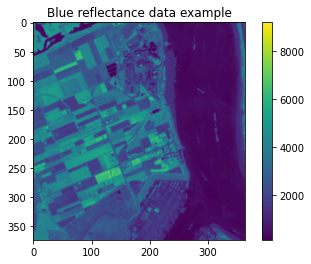

In [21]:
plt.imshow(test_img.read()[0]) #plot array as image
plt.title('Blue reflectance data example')
plt.colorbar()
plt.show()

In [22]:
lon, lat = test_img.lnglat()  # Get longitude and latitude
m = folium.Map(location=[lat, lon], zoom_start=12)

folium.raster_layers.ImageOverlay(
    image=test_img.read()[0],
    bounds=[[y1_test, x1_test], [y2_test, x2_test]],
    opacity=0.75,
).add_to(m)

m

# 4. Read Data

In the first step we open the required data.
The data is stored under the folder "Data".

## 4.1 Import files

In [25]:
# With this cell you check all the available tif files in the input_folder
input_folder=r'./data/S2A_20170526T105031_31UES_TOC' #define input_folder
input_fhs=sorted(glob.glob(input_folder+r'/*.tif')) #get list of tif files in the input_folder

input_fhs 

['./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B03_10m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B04_10m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B05_20m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B08_10m.tif']

Using xarray, open the following bands for both WET and DRY regions : 
- B02 (blue)
- B03 (green)
- B04 (red)
- B05 (red-edge/reg)
- B08 (nir)

In [26]:
blue = rioxarray.open_rasterio(input_fhs[0])
green = rioxarray.open_rasterio(input_fhs[1])
red = rioxarray.open_rasterio(input_fhs[2])
reg = rioxarray.open_rasterio(input_fhs[3])
nir = rioxarray.open_rasterio(input_fhs[4])

Print the size of the products to make sure everything is correctly opened

In [27]:
print("Blue Band dimensions:", blue.shape)
print("Green Band dimensions:", green.shape)
print("Red Band dimensions:", red.shape)
print("Red-edge Band dimensions:", reg.shape)
print("NIR Band dimensions:", nir.shape)

Blue Band dimensions: (1, 374, 364)
Green Band dimensions: (1, 374, 364)
Red Band dimensions: (1, 374, 364)
Red-edge Band dimensions: (1, 187, 182)
NIR Band dimensions: (1, 374, 364)


## 4.2 Metadata

Make sure to always check your meta data. Here you can find the properties and relevant information about your raster file, including size, nodata value, transform, spatial reference, projection, etc.

In [28]:
blue

<xarray.DataArray (band: 1, y: 374, x: 364)>
[136136 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.858e+05 5.858e+05 ... 5.894e+05 5.894e+05
  * y            (y) float64 5.687e+06 5.687e+06 ... 5.684e+06 5.684e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    32767.0
    scale_factor:  0.0001
    add_offset:    0.0
    long_name:     S2-MSI Band02, 10M resolution, Top Of Canopy Reflectance a...

In [29]:
# get the metadata from both the data array (rioxarray.open_rasterio)
# as wel as the dataset opened with rasterio.open
NDV = blue._FillValue
scale = blue.scale_factor
bands = blue.shape[0]
ysize = blue.shape[1]
xsize = blue.shape[2]
blue_meta = rasterio.open(input_fhs[0])
driver = blue_meta.driver
GeoT = blue_meta.transform
crs = blue_meta.crs

print('driver: {0} \nNodata Value: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}\nScale: {6}'.format(
   driver, NDV, xsize, ysize, GeoT, crs, scale)) #print metadata

driver: GTiff 
Nodata Value: 32767.0
xsize: 364
ysize: 374
GeoT: | 10.00, 0.00, 585800.00|
| 0.00,-10.00, 5687370.00|
| 0.00, 0.00, 1.00|
Projection: EPSG:32631
Scale: 0.0001


## 4.3 Export data

After a certain process, you might want to save a new raster as tif-file. This can be done with the following function with three inputs:
- source image (from which we copy the metadata)
- rasterdata (e.g., a 2D array)
- the name of the new file
This function will be demonstrated further on in the notebook

In [74]:
def write_file(src_img, data, outname):
    raster = rasterio.open(
        outname,
        "w",
        driver=src_img.driver,
        width=src_img.width,
        height=src_img.height,
        count=1,  # number of bands (1 for NDVI)
        crs=src_img.crs,
        transform=src_img.transform,
        dtype="float64",
    )
    raster.write(data, 1)
    raster.close()  # Do not forget to close opened file !

In [96]:
blue3 = rasterio.open(r'./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif').read()[0]
# blue3[blue3 == NDV] = np.nan
blue3 = blue3*scale
blue3[blue3 == NDV*scale]

array([], dtype=float64)

In [ ]:
BLU[BLU == NDV] = np.nan
BLU = BLU*0.0001

# 5. Preprocessing

As you probabmy will have noticed in the metadata, not all images have the same size. The red edge band for example, has a resolution of 20m instead of 10m. In order to combine the two resolutions, the red edge data needs to be resampled to match the rasters of the other bands. Furthermore, someties we are only interested in a part of the area covered in the image. To improve computation efficiency, we can crop the data to only our region of interest. In adition, the data comes with a scale factor that needs to be applied before actual calculation can happen. 

These types of preprocessing can be easily executed with the GDAL package and will be covered in the following section.

## 5.1 Resample 20m data to 10m data using *gdal.Warp*

Now that we know how to read, import, adjust and write rasters, we are one step closer to do raster analysis in python! However, the dataset we use, often come in different shapes, resolutions, projections etc. If we want to do raster analysis or calculations, the rasters in questions need to match perfectly. For example the Red-Edge band has a resolution of 20m, whereas the other bands have a resolution of 10m. In order to deal with this, we can use the This can be done using the *gdal.Warp* function, an image mosaicing, reprojection and warping function. 

First, get info on the target/destination file and on the source file 

In [31]:
dst_info=gdal.Info(gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif'),format='json') # destination info, which projection/resolution do we want? (here blue band)
src_info=gdal.Info(gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B05_20m.tif'),format='json') # source info, the file we want to alter (here REG band)

After getting source *src_info* and target info *dst_info*, we can fill in these information to *gdal.Warp* as follow. The function will then resample the Red-Edge band raster data values to the same resolution as the blue band raster. If the *gdal.Warp* function finished successfully, it will return a *osgeo.gdal.Dataset* object and the output raster file will be save in the output folder.

In [32]:
source_file=r'./data/S2A_20170526T105031_31UES_TOC/B05_20m.tif'
output_folder=r'./data/S2A_20170526T105031_31UES_TOC'
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_file=os.path.join(output_folder,filename.replace('20m','10m')[:-4] + '.tif') #create a output file path

gdal.Warp(output_file,source_file,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f5dc6d92d50> >

Now check if the dimensions of the new file are altered:

In [33]:
reg2 = rioxarray.open_rasterio(r'./data/S2A_20170526T105031_31UES_TOC/B05_10m.tif')
print("New red-edge Band dimensions:", reg2.shape)

New red-edge Band dimensions: (1, 374, 364)


## 5.2 Crop raster to shapefile

As you will notice, some satellite products cover a large area. At high resolution this takes a lot of storage and computational power to execute your analysis. Therefore, it is useful to crop your rasters to only your area of interest. The following section will provide the necessary tools to execute this preprocessing step. 

First, we get the path to the input raster file and create an outputfolder

In [35]:
input_fh=r"./data/S2A_20170526T105031_31UES_TOC/B08_10m.tif" # path to the raster to be clipped
shp_fh=r"./data/S2A_20170526T105031_31UES_TOC/Shapefile/RegionOfInterest.shp" #path to the shapefile containing polygon of region of interest

output_folder=r'./data/S2A_20170526T105031_31UES_TOC/ROI'#path to output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(input_fh) #get filename from source_file path
output_fh=os.path.join(output_folder,filename[:-4] + '_crop.tif') #create a output file path
print(output_fh)

./data/S2A_20170526T105031_31UES_TOC/ROI/B08_10m_crop.tif


After defining the input and ouput raster file and the shapefile paths, we can use *ogr* library function to read shapefile dataset as gdal object to get the layer name. Then, use the shapefile path and layer as options arguments for *gdal.Warp* function.

In [36]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #read shapefile as gdal dataset
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

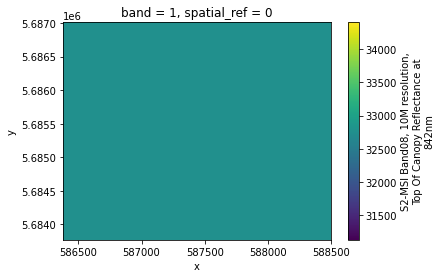

In [37]:
output_array=rioxarray.open_rasterio(r'./data/S2A_20170526T105031_31UES_TOC/ROI/B08_10m_crop.tif')
output_array.plot()

Below is the map after clipping:

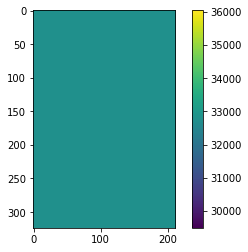

In [43]:
output_array=rasterio.open(r'./data/S2A_20170526T105031_31UES_TOC/ROI/B08_10m_crop.tif').read()[0]
plt.imshow(output_array)
plt.colorbar()
plt.show()

**In section 5.2 he returns na values for all the pixels in the raster...**

## 5.3 Applying the scale factor

First we are going to have a look at the scae factor. This is a simple conversion, by just multiplying the DataArray with the scale factor provided in the metadata. 

In [63]:
# Maybe some usefull code to convert the NDV to nan?
# noval = np.where((d_red == 32767) | (d_red < 0) | (d_nir == 32767) | (d_nir < 0))    
# d_red[noval] = np.nan
# d_nir[noval] = np.nan

blue2 = blue*scale
green2 = green*scale
red2 = red*scale
reg2 = reg2*scale
nir2 = nir*scale

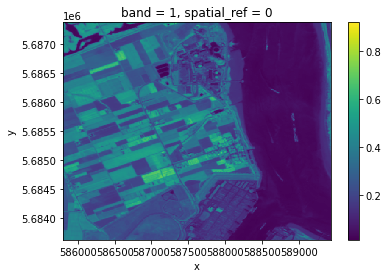

In [65]:
nir2.plot()

Now that our data is preprocessed and our layers match, we can put the layers in 1 Xarray. To keep an overview, it is best that the name of the bands is altered within the DataArray:

In [66]:
blue2["band"] = ["blue"]
green2["band"] = ["green"]
red2["band"] = ["red"]
reg2["band"] = ["reg"]
nir2["band"] = ["nir"]
blue2

<xarray.DataArray (band: 1, y: 374, x: 364)>
array([[[0.0266, 0.0281, 0.0297, ..., 0.0727, 0.0448, 0.0432],
        [0.0274, 0.0271, 0.0278, ..., 0.0783, 0.05  , 0.0397],
        [0.0276, 0.0286, 0.0288, ..., 0.086 , 0.0484, 0.0424],
        ...,
        [0.0172, 0.0184, 0.0184, ..., 0.0582, 0.0569, 0.0555],
        [0.0169, 0.0202, 0.0181, ..., 0.0542, 0.0525, 0.0555],
        [0.018 , 0.0194, 0.0193, ..., 0.0551, 0.0551, 0.0539]]])
Coordinates:
  * band         (band) <U4 'blue'
  * x            (x) float64 5.858e+05 5.858e+05 ... 5.894e+05 5.894e+05
  * y            (y) float64 5.687e+06 5.687e+06 ... 5.684e+06 5.684e+06
    spatial_ref  int64 0

In [68]:
stack = xarray.concat([blue2, green2, red2, reg2, nir2], dim="band")
stack

<xarray.DataArray (band: 5, y: 374, x: 364)>
array([[[0.0266, 0.0281, 0.0297, ..., 0.0727, 0.0448, 0.0432],
        [0.0274, 0.0271, 0.0278, ..., 0.0783, 0.05  , 0.0397],
        [0.0276, 0.0286, 0.0288, ..., 0.086 , 0.0484, 0.0424],
        ...,
        [0.0172, 0.0184, 0.0184, ..., 0.0582, 0.0569, 0.0555],
        [0.0169, 0.0202, 0.0181, ..., 0.0542, 0.0525, 0.0555],
        [0.018 , 0.0194, 0.0193, ..., 0.0551, 0.0551, 0.0539]],

       [[0.0695, 0.068 , 0.0503, ..., 0.0887, 0.0758, 0.0695],
        [0.0708, 0.0697, 0.0553, ..., 0.0963, 0.0751, 0.0692],
        [0.0716, 0.0704, 0.0659, ..., 0.101 , 0.08  , 0.0728],
        ...,
        [0.0304, 0.0316, 0.03  , ..., 0.0772, 0.0764, 0.0753],
        [0.0314, 0.0332, 0.0334, ..., 0.0758, 0.076 , 0.0772],
        [0.0313, 0.0314, 0.0323, ..., 0.0747, 0.0733, 0.0741]],

       [[0.0273, 0.0298, 0.0331, ..., 0.0969, 0.0699, 0.0663],
        [0.0307, 0.03  , 0.0318, ..., 0.1076, 0.0786, 0.068 ],
        [0.0333, 0.0311, 0.0333, ..., 0.1206, 0.0764, 0.0725],
        ...,
        [0.0176, 0.0171, 0.0171, ..., 0.0778, 0.0749, 0.0749],
        [0.0171, 0.0182, 0.0171, ..., 0.0729, 0.0735, 0.0753],
        [0.0171, 0.019 , 0.0178, ..., 0.0697, 0.0697, 0.0702]],

       [[0.1082, 0.1082, 0.0659, ..., 0.1226, 0.1203, 0.1203],
        [0.127 , 0.127 , 0.075 , ..., 0.1277, 0.1291, 0.1291],
        [0.127 , 0.127 , 0.075 , ..., 0.1277, 0.1291, 0.1291],
        ...,
        [0.0442, 0.0442, 0.061 , ..., 0.0728, 0.0731, 0.0731],
        [0.0442, 0.0442, 0.061 , ..., 0.0728, 0.0731, 0.0731],
        [3.2767, 3.2767, 3.2767, ..., 3.2767, 3.2767, 3.2767]],

       [[0.5124, 0.4376, 0.1842, ..., 0.1798, 0.2652, 0.28  ],
        [0.4928, 0.4628, 0.2706, ..., 0.1646, 0.2566, 0.2754],
        [0.472 , 0.4796, 0.3776, ..., 0.1618, 0.2618, 0.2696],
        ...,
        [0.399 , 0.399 , 0.4038, ..., 0.0414, 0.0418, 0.0408],
        [0.3934, 0.399 , 0.405 , ..., 0.0347, 0.0359, 0.0386],
        [0.3946, 0.3964, 0.4016, ..., 0.0341, 0.0324, 0.0333]]])
Coordinates:
  * band         (band) <U5 'blue' 'green' 'red' 'reg' 'nir'
  * x            (x) float64 5.858e+05 5.858e+05 ... 5.894e+05 5.894e+05
  * y            (y) float64 5.687e+06 5.687e+06 ... 5.684e+06 5.684e+06
    spatial_ref  int64 0

To be sure, you can clean data arrays by replacing N/A values by zero

In [69]:
stack = stack.fillna(0)

# 6. Vegetation Index Computation

## 6.1 NDVI

Now let's have a look at some vegetation indices. First we will calculate the NDVI by selecting the right backs from our stack of arrays. As you can recall from the slides, its formula is the following:

$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$

In [70]:
NDVI = (stack.sel(band="nir") - stack.sel(band="red")) / (
    stack.sel(band="nir") + stack.sel(band="red")
)
NDVI = NDVI.fillna(0)  # Clean NDVI data

Plot the NDVI map

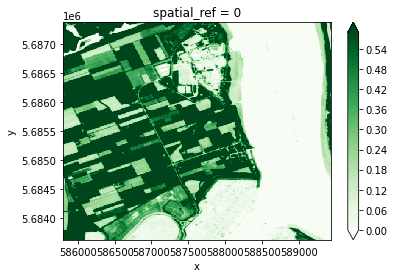

In [84]:
NDVI.plot(levels=np.arange(0, 0.6, 0.01), cmap="Greens")

How can you interpret the map, where are the high and low NDVI values and with what landcover do they belong?

When you are happy with the result, you can save the map as a tif-file with the *write_file* function, earlier developed in this notebook: 

In [75]:
src_img = rasterio.open("./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif")
write_file(src_img, NDVI, "./data/S2A_20170526T105031_31UES_TOC/NDVI.tif")

Check the saved file:

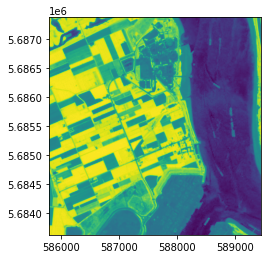

<AxesSubplot:>

In [76]:
ndvi = rasterio.open("./data/S2A_20170526T105031_31UES_TOC/NDVI.tif")
show(ndvi)

## 6.2 Other VI's

Now try to calculate the vegetation indices below:

_Enhanced Vegetation Index (EVI):_
$$
EVI = 2.5*\frac{NIR - RED}{(NIR+6*RED - 7.5*BLUE) + 1}
$$
_Normalized Difference Red Edge Index (NDRE):_
$$
NDRE = \frac{NIR - REG}{NIR + REG}
$$

More vegetation indices can be found on the Index DataBase website: https://www.indexdatabase.de/

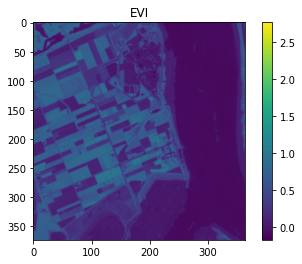

In [81]:
# EVI:

EVI = 2.5*(stack.sel(band="nir")-stack.sel(band="red")) / (
    (stack.sel(band="nir")+6*stack.sel(band="red")-7.5*stack.sel(band="blue"))+1)
plt.imshow(EVI)
plt.colorbar()
plt.title('EVI')
plt.show()

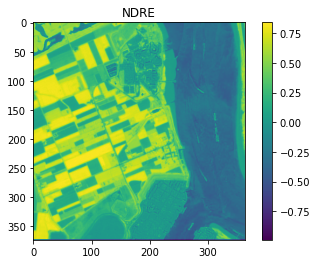

In [82]:
# NDRE

NDRE = (stack.sel(band="nir") - stack.sel(band="reg"))/(stack.sel(band="nir") + stack.sel(band="reg"))
plt.imshow(NDRE)
plt.colorbar()
plt.title('NDRE')
plt.show()

# ----------------------------------------------------------------

Below some scripts from another aproach with reading and writing with gdal

In [38]:
blue_meta = rasterio.open(input_fhs[0])
driver = blue_meta.driver
xsize = blue_meta
GeoT = blue_meta.transform
Projection = osr.SpatialReference() # Spatial reference system of raster
Projection.ImportFromWkt(blue_meta.GetProjectionRef())

print('driver: {0} \nNodata Value: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
   driver, NDV, xsize, ysize, GeoT, Projection)) #print metadata

<open DatasetReader name='./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif' mode='r'>

In [97]:
DataSet = gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif', gdal.GA_ReadOnly) #open raster in in_fh path

Type = DataSet.GetDriver().ShortName #GDAL driver
bandnumber=1 
Subdataset = DataSet.GetRasterBand(bandnumber) #Get the subdataset of band 1
NDV = Subdataset.GetNoDataValue() # No data value
xsize = DataSet.RasterXSize # number of columns in raster
ysize = DataSet.RasterYSize # number of rows in raster
GeoT = DataSet.GetGeoTransform() # Geo-transformation (coordinate of corner pixels)
Projection = osr.SpatialReference() # Spatial reference system of raster
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNodata Value: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
   driver, NDV, xsize, ysize, GeoT, Projection)) #print metadata

driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x7f8b83e87210> > 
Nodata Value: 32767.0
xsize: 364
ysize: 374
GeoT: (585800.0, 10.0, 0.0, 5687370.0, 0.0, -10.0)
Projection: PROJCS["WGS 84 / UTM zone 31N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32631"]]


To convert a raster file to a usable array, you can make use of the function *ReadAsArray* function. For example, the below code is used to read the opened GeoTIFF dataset as a numpy array. The code is put into a definition for convience as we need to read and load several rasters. Note that the no data values (NDV) are converted to nan. 

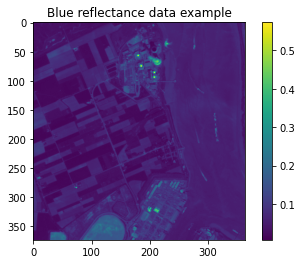

In [98]:
Array = Subdataset.ReadAsArray().astype(np.float32) #read sub-dataset as numpy array
Array[Array == NDV] = np.nan #replace No Data value with NAN value
NewArray = Array*0.0001 # multiply with scale factor

plt.imshow(NewArray) #plot array as image
plt.title('Blue reflectance data example')
plt.colorbar()
plt.show()

We can save this scaled blue reflectance data as a new raster file. To save our result as a raster file (GeoTIFF), we need to know the properties of the original raster file (driver, Nodata Value, size, extent, projection). Below is the example to save the above array as a new raster file. First, the output file name is defined and the output folder is created if it does not exist.

In [6]:
output_folder=r'.\Sentinel-2\Scaled_Reflectance_Data'
if not os.path.exists(output_folder): #check if output_folder exists
    os.makedirs(output_folder) #if not create the output_folder
filename=os.path.basename(in_fh) #get filename of the input file
out_fh=os.path.join(output_folder,filename[:-4] + '_SCALED.tif') #output file path is defined
print(out_fh)

.\Sentinel-2\Scaled_Reflectance_Data\S2A_20170526T105031_31UES_TOC-B02_10M_V200_SCALED.tif


In [7]:
datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32']) #create dataset from driver
DataSet.GetRasterBand(1).SetNoDataValue(NDV) #set Nodata value of the new dataset
DataSet.SetGeoTransform(GeoT) #set Geotransformation
DataSet.SetProjection(Projection.ExportToWkt()) 
DataSet.GetRasterBand(1).WriteArray(NewArray) #write the CorrectedArray values to the new dataset
print(out_fh)

.\Sentinel-2\Scaled_Reflectance_Data\S2A_20170526T105031_31UES_TOC-B02_10M_V200_SCALED.tif


The procedure, desccribed above, to load tif files as arrays can easily be put into a function. This function allows for easy conversion in the future.

In [99]:
def GetGeoInfo(fh, subdataset = 0):
    '''
    This function extracts metadata from a GeoTIFF, HDF4 or netCDF file.      
    ''' 
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly) #open raster with path fh
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)

    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    '''
    This function read a GeoTIFF or HDF4 file as an numpy array.
    ''' 
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16,
                 "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
                 "int32": np.int32, "float32": np.float32, "float64": np.float64, 
                 "complex64": np.complex64, "complex128": np.complex128,
                "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, 
                 "Complex64": np.complex64, "Complex128": np.complex128,}
                 
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan

    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, 
                  Projection, explicit = True, compress = None):      
    '''
    This function saves a numpy array as a GeoTIFF raster file.
    ''' 

    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
        "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
        "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan

# Warp rasterfiles

Now that we know how to read, import, adjust and write rasters, we are one step closer to do raster analysis in python! However, the dataset we use, often come in different shapes, resolutions, projections etc. If we want to do raster analysis or calculations, the rasters in questions need to match perfectly. For example the Red-Edge band has a resolution of 20m, whereas the other bands have a resolution of 10m. In order to deal with this, we can use the This can be done using the *gdal.Warp* function, an image mosaicing, reprojection and warping function. 

The *gdal.Warp* is used to warp the given raster data to pre-defined data size and spatial extent, reproject it to pre-defined spatial reference system.
To *gdal.Warp* a raster file to match projection, size, extent with another raster file, the information of the target file need to be obtained first. 
The below function is to get nodata value, spatial reference system, data size, spatial extent of a raster file using *gdal* package. 

In [100]:
dst_info=gdal.Info(gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif'),format='json') # destination info, which projection/resolution do we want? (here blue band)
src_info=gdal.Info(gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B05_20m.tif'),format='json') # source info, the file we want to alter (here REG band)

print('Target info: ',dst_info,'\n')
print('Source info: ',src_info)

Target info:  {'description': './data/S2A_20170526T105031_31UES_TOC/B02_10m.tif', 'driverShortName': 'GTiff', 'driverLongName': 'GeoTIFF', 'files': ['./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif'], 'size': [364, 374], 'coordinateSystem': {'wkt': 'PROJCRS["WGS 84 / UTM zone 31N",\n    BASEGEOGCRS["WGS 84",\n        DATUM["World Geodetic System 1984",\n            ELLIPSOID["WGS 84",6378137,298.257223563,\n                LENGTHUNIT["metre",1]]],\n        PRIMEM["Greenwich",0,\n            ANGLEUNIT["degree",0.0174532925199433]],\n        ID["EPSG",4326]],\n    CONVERSION["UTM zone 31N",\n        METHOD["Transverse Mercator",\n            ID["EPSG",9807]],\n        PARAMETER["Latitude of natural origin",0,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8801]],\n        PARAMETER["Longitude of natural origin",3,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8802]],\n        PARAMETER["Scale factor at natural origin",0.9996,\n 

After getting source *src_info* and target info *dst_info*, we can fill in these information to *gdal.Warp* as follow. The function will then resample the Red-Edge band raster data values to the same resolution as the blue band raster. If the *gdal.Warp* function finished successfully, it will return a *osgeo.gdal.Dataset* object and the output raster file will be save in the output folder.

In [101]:
source_file=r'./data/S2A_20170526T105031_31UES_TOC/B05_20m.tif'
output_folder=r'./data/S2A_20170526T105031_31UES_TOC/warped'
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_file=os.path.join(output_folder,filename.replace('20m','10m')[:-4] + '_WARPED.tif') #create a output file path

gdal.Warp(output_file,source_file,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f8b83e450f0> >

Also the Warping procedure can easily be put into a self made function:

In [13]:
def MatchProjResNDV(target_file, source_file, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    This function warp all the raster files in a list to the same size, 
    resolution, and projection with a source raster file.
    """
    dst_info=gdal.Info(gdal.Open(target_file),format='json')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    folder, fn = os.path.split(source_file)
    src_info=gdal.Info(gdal.Open(source_file),format='json')
    output_file = os.path.join(output_dir, fn[:-4] + '_Warped.tif')
    gdal.Warp(output_file,source_file,format='GTiff',
                  srcSRS=src_info['coordinateSystem']['wkt'],
                  dstSRS=dst_info['coordinateSystem']['wkt'],
                  srcNodata=src_info['bands'][0]['noDataValue'],
                  dstNodata=dst_info['bands'][0]['noDataValue'],
                  width=dst_info['size'][0],
                  height=dst_info['size'][1],
                  outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                dst_info['cornerCoordinates']['lowerLeft'][1],
                                dst_info['cornerCoordinates']['upperRight'][0],
                                dst_info['cornerCoordinates']['upperRight'][1]),
                  outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                  resampleAlg=resample)
    if not np.any([scale == 1.0, scale == None, scale == 1]):
        driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
        DATA = OpenAsArray(output_file, nan_values = True) * scale
        CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    if ndv_to_zero:
        driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
        DATA = OpenAsArray(output_file, nan_values = False)
        DATA[DATA == NDV] = 0.0
        CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_file

# Crop Rasterfiles

As you will notice, some satellite products cover a large area. At high resolution this takes a lot of storage and computational power to execute your analysis. Therefore, it is useful to crop your rasters to only your area of interest. The following section will provide the necessary tools to execute this preprocessing step. 

First, we get the path to the input raster file and create an outputfolder

In [68]:
input_fh=r"./data/S2A_20170526T105031_31UES_TOC/B08_10m.tif" # path to the raster to be clipped
shp_fh=r"./data/S2A_20170526T105031_31UES_TOC/Shapefile/RegionOfInterest.shp" #path to the shapefile containing polygon of region of interest

output_folder=r'./data/S2A_20170526T105031_31UES_TOC/ROI'#path to output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #get filename from source_file path
output_fh=os.path.join(output_folder,filename[:-4] + '_crop.tif') #create a output file path
print(output_fh)

./data/S2A_20170526T105031_31UES_TOC/ROI/B05_20m_crop.tif


After defining the input and ouput raster file and the shapefile paths, we can use *ogr* library function to read shapefile dataset as gdal object to get the layer name. Then, use the shapefile path and layer as options arguments for *gdal.Warp* function.

In [15]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #read shapefile as gdal dataset
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

Below is the map after clipping:

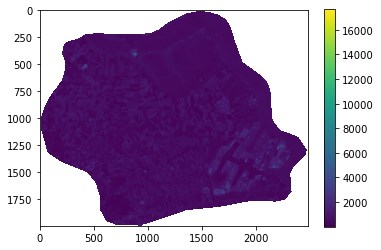

In [16]:
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

Once again, this preprocessing task can be put into a function:

In [21]:
def CliptoShp(input_fh,output_folder,shp_fh,NDV=-9999):
    """
    Clip raster to boundary line of a shapefile
    
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )

    output_fh=os.path.join(output_folder,os.path.basename(input_fh)[:-4] + '_Clipped.tif')
    sourceds = gdal.Warp(output_fh, input_fh, options = options)
        
    return

# Raster calculation

Now that we have seen how raster data can be preprocessed, we will have a look at small raster calculation examples. In the following section we will calculate some spectral vegetation indices. In order to do this we first need to import reflectance values.

In [18]:
# First convert the red edge raster at 20m resolution to 10m resolution. This can be don with the MatchProjResNDV function

source_fh=r'.\Sentinel-2\Sentinel_20m\S2A_20170526T105031_31UES_TOC-B05_20M_V200.tif'
target_fh=r'.\Sentinel-2\S2A_20170526T105031_31UES_TOC-B02_10M_V200.tif'
output_folder=r'.\Sentinel-2\Warped'
MatchProjResNDV(target_fh, source_fh, output_folder)

'.\\Sentinel-2\\Warped\\S2A_20170526T105031_31UES_TOC-B05_20M_V200_Warped.tif'

In [75]:
# Now we need to clip the data to our desired extent

output_folder=r'.\Sentinel-2\Sentinel_preprocessed' #output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
shp = '.\Sentinel-2\Shapefile\RegionOfInterest.shp'

input = '.\Sentinel-2\S2A_20170526T105031_31UES_TOC-B02_10M_V200.tif'
CliptoShp(input,output_folder,shp)
input = '.\Sentinel-2\S2A_20170526T105031_31UES_TOC-B03_10M_V200.tif'
CliptoShp(input,output_folder,shp)
input = '.\Sentinel-2\S2A_20170526T105031_31UES_TOC-B04_10M_V200.tif'
CliptoShp(input,output_folder,shp)
input = '.\Sentinel-2\S2A_20170526T105031_31UES_TOC-B08_10M_V200.tif'
CliptoShp(input,output_folder,shp)
input = '.\Sentinel-2\Warped\S2A_20170526T105031_31UES_TOC-B05_20M_V200_Warped.tif'
CliptoShp(input,output_folder,shp)

In [102]:
# Read the rasters as numpy array:

input_folder = r'.\Sentinel-2\Sentinel_preprocessed'
input_fhs = sorted(glob.glob(input_folder+'\*.tif')) #get list of tif files in the input_folder

BLU = OpenAsArray(input_fhs[0],nan_values=True)
BLU[BLU == NDV] = np.nan
BLU = BLU*0.0001
GRE = OpenAsArray(input_fhs[1],nan_values=True)
GRE[GRE == NDV] = np.nan
GRE = GRE*0.0001
RED = OpenAsArray(input_fhs[2],nan_values=True)
RED[RED == NDV] = np.nan
RED = RED*0.0001
REG = OpenAsArray(input_fhs[3],nan_values=True)
REG[REG == NDV] = np.nan
REG = REG*0.0001
NIR = OpenAsArray(input_fhs[4],nan_values=True)
NIR[NIR == NDV] = np.nan
NIR = NIR*0.0001


Now that we have our clipped, warped and scaled raster data (reflectance data), we can calculate several vegetation indices

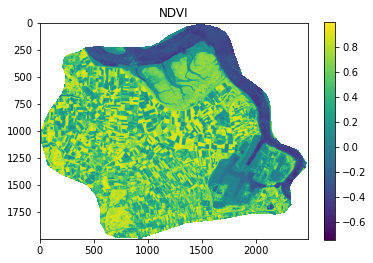

In [91]:
# NDVI:

NDVI = (NIR-RED)/(NIR+RED)
plt.imshow(NDVI)
plt.colorbar()
plt.title('NDVI')
plt.show()

# Write Raster 
output_folder=r'.\Sentinel-2\Vegetation_Indices' #output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo('.\Sentinel-2\Sentinel_preprocessed\S2A_20170526T105031_31UES_TOC-B02_10M_V200_Clipped.tif')
CreateGeoTiff((output_folder + r'\NDVI.tif'), NDVI, driver, NDV, xsize, ysize, GeoT, 
                  Projection)

# Open the saved raster
# output_array=OpenAsArray(r'.\Sentinel-2\Sentinel_preprocessed\NDVI.tif',nan_values=True)
# plt.imshow(output_array)
# plt.colorbar()
# plt.show()

Now try to calculate the vegetation indices below:

_Enhanced Vegetation Index (EVI):_
$$
EVI = 2.5*\frac{NIR - RED}{(NIR+6*RED - 7.5*BLUE) + 1}
$$
_Normalized Difference Red Edge Index (NDRE):_
$$
NDRE = \frac{NIR - REG}{NIR + REG}
$$

More vegetation indices can be found on the Index DataBase website: https://www.indexdatabase.de/

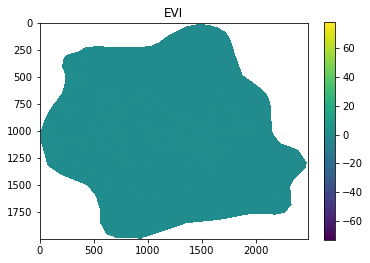

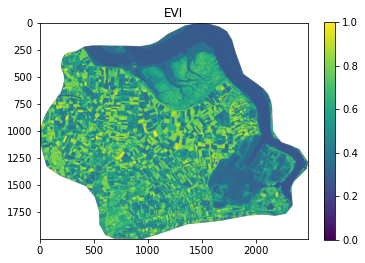

In [107]:
# EVI:

EVI = 2.5*(NIR-RED)/((NIR+6*RED-7.5*BLU)+1)
plt.imshow(EVI)
plt.colorbar()
plt.title('EVI')
plt.show()

# Alter the range of the map
cmap = plt.cm.viridis
norm = plt.Normalize(-0.5, 1)
rgba = cmap(norm(EVI))

plt.imshow(rgba)
plt.colorbar()
plt.title('EVI')
plt.show()

# Write Raster 
output_folder=r'.\Sentinel-2\Vegetation_Indices' #output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo('.\Sentinel-2\Sentinel_preprocessed\S2A_20170526T105031_31UES_TOC-B02_10M_V200_Clipped.tif')
CreateGeoTiff((output_folder + r'\EVI.tif'), EVI, driver, NDV, xsize, ysize, GeoT, 
                  Projection)

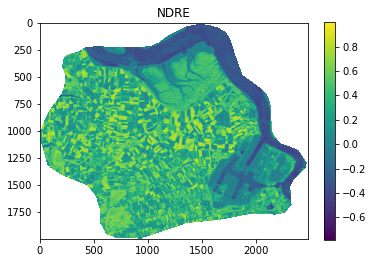

In [97]:
# NDRE

NDRE = (NIR - REG)/(NIR + REG)
plt.imshow(NDRE)
plt.colorbar()
plt.title('NDRE')
plt.show()